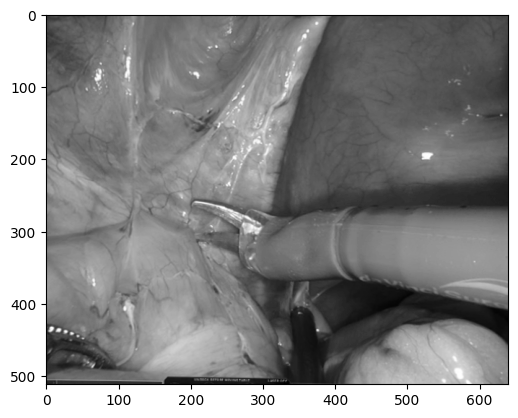

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
img = cv2.imread('data/endonerf_cutting/images/frame-000000.color.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')



In [2]:
import torch
torch.tensor(img)
img.shape

(512, 640)

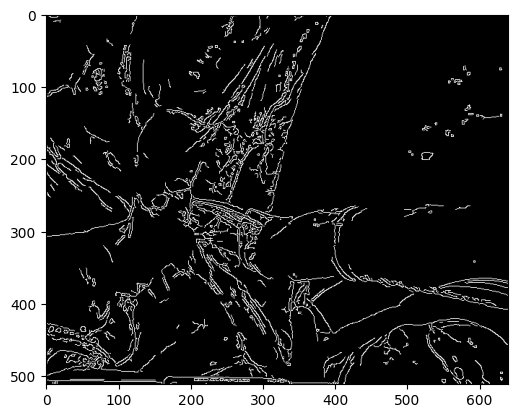

In [3]:
edges = cv2.Canny(img,50,100)
plt.imshow(edges,cmap='gray')
plt.show()

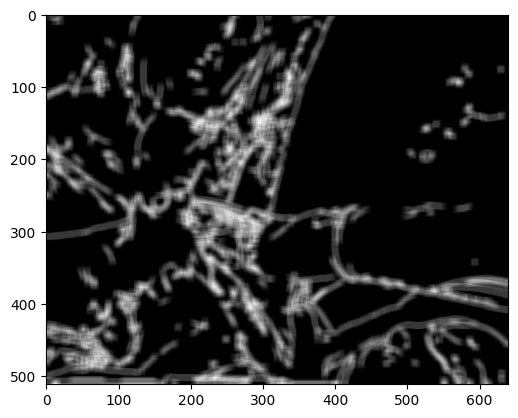

In [4]:
blur = cv2.blur(edges,(10,10))
plt.imshow(blur,cmap='gray')
plt.show()

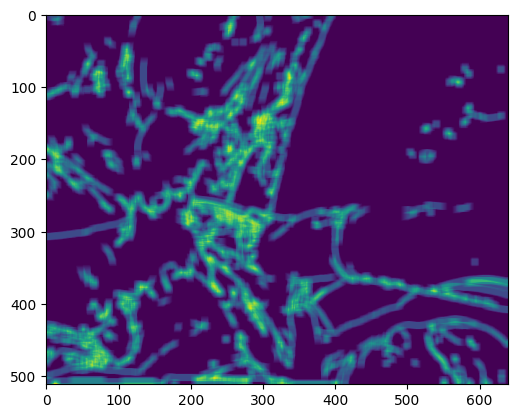

In [5]:
blur_norm = (blur-blur.min())/(blur.max()-blur.min())
plt.imshow(blur_norm)
plt.show()

In [6]:
(512*640)/2

163840.0

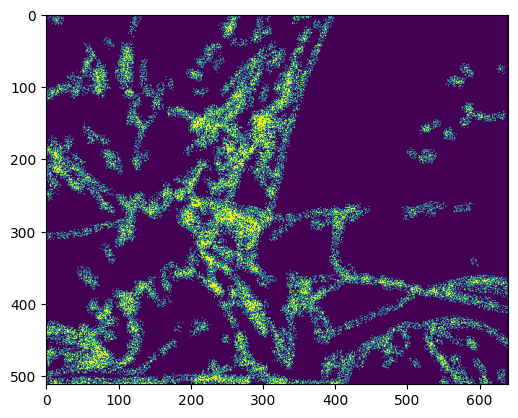

In [7]:
randomness = np.random.uniform(0,1,blur_norm.shape)
blur_norm_prob = blur_norm+randomness
plt.imshow(blur_norm_prob>1)


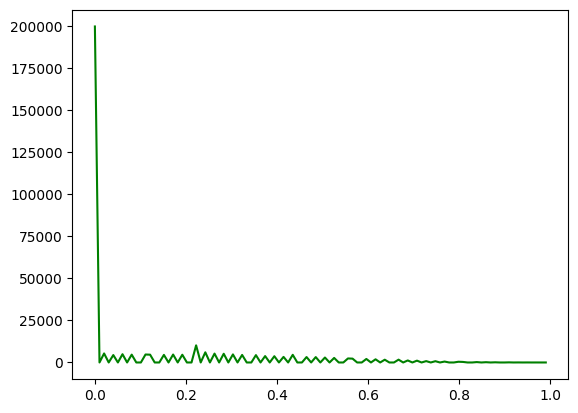

In [8]:
bins = torch.linspace(0,1,100,dtype=torch.float64)
hist1 = torch.histogram(torch.tensor(blur_norm_prob), bins = bins)
hist2 = torch.histogram(torch.tensor(blur_norm), bins = bins)
hist3  = torch.histogram(torch.tensor(randomness), bins = bins)

# plt.plot(hist1.bin_edges[:-1],hist1.hist,color = 'r')
plt.plot(hist2.bin_edges[:-1],hist2.hist,color = 'g')
# plt.plot(hist2.bin_edges[:-1],hist2.hist,color = 'b')
# plt.legend(['blur_norm_prob','blur_norm','randomness'])

In [9]:
blur_norm.shape

(512, 640)

In [10]:
blur_norm.max()

1.0

In [11]:
prob_map = blur_norm/blur_norm.sum()
random_indices = np.random.choice(np.arange(blur_norm.shape[0]*blur_norm.shape[1]), size = int(blur_norm.shape[0]*blur_norm.shape[1]*0.5), p = prob_map.flatten())

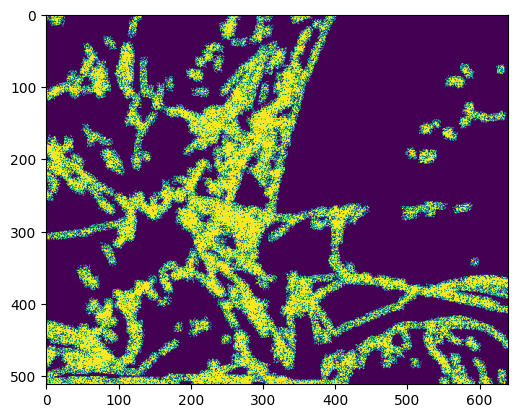

In [12]:
mask = np.zeros(blur_norm.shape[0]*blur_norm.shape[1])
mask[random_indices] = 1
plt.imshow(mask.reshape(blur_norm.shape))

(512, 640)
(327680,)
(512, 640)
(512, 640)
(327680,)
(512, 640)


(-0.5, 639.5, 511.5, -0.5)

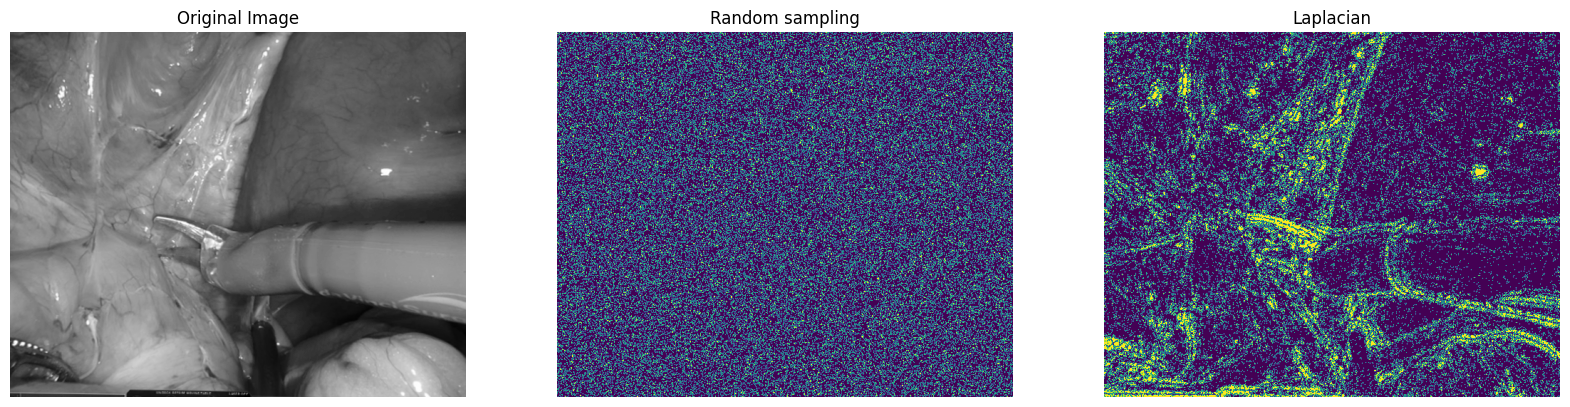

In [25]:
import torch
import numpy as np
import cv2
import torchvision

def texture_mask_laplacian(image_tensor: torch.Tensor, num_samples: int, ksize: int = 3):
    height = image_tensor.shape[1]
    width = image_tensor.shape[2]
    image_grayscale = torchvision.transforms.functional.rgb_to_grayscale(image_tensor)
    # Convert to NumPy uint8
    image_np = image_grayscale.squeeze().cpu().numpy()
    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    else:
        image_np = image_np.astype(np.uint8)

    # Apply Laplacian to get texture response
    laplacian = cv2.Laplacian(image_np, ddepth=cv2.CV_32F, ksize=ksize)
    texture_strength = np.abs(laplacian)
    print(texture_strength.shape)
    # Normalize texture map to probability distribution
    texture_strength += 1e-6  # prevent division by zero
    prob_map = texture_strength / texture_strength.sum()

    # Flatten and sample
    flat_indices = np.arange(height * width)
    print(flat_indices.shape)
    print(texture_strength.shape)
    sampled_indices = np.random.choice(flat_indices, size=num_samples, replace=False, p=prob_map.flatten())

    # Create mask
    mask = np.zeros(height * width, dtype=np.uint8)
    mask[sampled_indices] = 1
    mask = mask.reshape(height, width)

    return torch.from_numpy(mask).unsqueeze(0).float()


mask1 = texture_mask_laplacian(torch.tensor(img).unsqueeze(0), num_samples=(blur.shape[0]*blur.shape[1])//5, ksize=31)
mask2 = texture_mask_laplacian(torch.tensor(img).unsqueeze(0), num_samples=(blur.shape[0]*blur.shape[1])//5, ksize=3)
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(np.random.uniform(0,1,img.shape)>0.8)
ax[1].set_title("Random sampling")
ax[2].imshow(mask1.squeeze().numpy())
ax[2].set_title('Laplacian')
# ax[3].set_title('Laplacian ksize=3')
# ax[3].imshow(mask2.squeeze().numpy())
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
# ax[3].axis("off")


In [17]:
num_samples=(blur.shape[0]*blur.shape[1])//5
print(f"Number of samples: {num_samples}, image size: {blur.shape[0]*blur.shape[1]}, sampling ratio: {num_samples/(blur.shape[0]*blur.shape[1])}")

Number of samples: 65536, image size: 327680, sampling ratio: 0.2


In [20]:
a = (np.random.uniform(0,1,img.shape)>0.8).sum()
a/327680

0.1994537353515625